ergrant jborromeo SYDE 552 Final Project

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import keras_spiking

tf.random.set_seed(0)
np.random.seed(0)

In [58]:
# Load MNIST Digits Dataset
((train_images, train_labels),(test_images, test_labels),) = tf.keras.datasets.mnist.load_data()

image_size = train_images.shape[1]

# normalize images so values are between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

class_names = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9"
]
num_classes = len(class_names)

## Non-Spiking Model for Comparison

In [40]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=train_images.shape[1:]),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(num_classes),
    ]
)


def train(input_model, train_x, test_x):
    input_model.compile(
        optimizer="adam",
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    input_model.fit(train_x, train_labels, epochs=10)

    _, test_acc = input_model.evaluate(test_x, test_labels, verbose=2)

    print("\nTest accuracy:", test_acc)


train(model, train_images, test_images)

Epoch 1/10
1875/1875 [==============================] - 2s 747us/step - loss: 0.4281 - accuracy: 0.8811
Epoch 2/10
1875/1875 [==============================] - 1s 650us/step - loss: 0.1128 - accuracy: 0.9677
Epoch 3/10
1875/1875 [==============================] - 1s 776us/step - loss: 0.0795 - accuracy: 0.9763
Epoch 4/10
1875/1875 [==============================] - 1s 646us/step - loss: 0.0585 - accuracy: 0.9826
Epoch 5/10
1875/1875 [==============================] - 1s 642us/step - loss: 0.0385 - accuracy: 0.9891
Epoch 6/10
1875/1875 [==============================] - 1s 645us/step - loss: 0.0320 - accuracy: 0.9904
Epoch 7/10
1875/1875 [==============================] - 1s 647us/step - loss: 0.0242 - accuracy: 0.9930
Epoch 8/10
1875/1875 [==============================] - 1s 648us/step - loss: 0.0207 - accuracy: 0.9940
Epoch 9/10
1875/1875 [==============================] - 1s 650us/step - loss: 0.0166 - accuracy: 0.9952
Epoch 10/10
1875/1875 [==============================] - 1s 656u

## Conversion to Spiking Model

In [59]:
# repeat the images for n_steps
n_steps = 10
train_sequences = np.tile(train_images[:, None], (1, n_steps, 1, 1))
test_sequences = np.tile(test_images[:, None], (1, n_steps, 1, 1))

In [96]:
# use dt = 0.03 going forward: balance between low timesteps and good-ish accuracy
dt_from_prev = 0.03

In [97]:
spikeaware_model = tf.keras.Sequential(
    [
        tf.keras.layers.Reshape((-1, image_size * image_size), input_shape=(None, image_size, image_size)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128)),
        # set spiking_aware training and a moderate dt
        keras_spiking.SpikingActivation("relu", dt=dt_from_prev, spiking_aware_training=True),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(num_classes),
    ]
)

# train the model, identically to the non-spiking version,
# except using the time sequences as inputs
train(spikeaware_model, train_sequences, test_sequences)

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.7277 - accuracy: 0.7663
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2356 - accuracy: 0.9278
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1754 - accuracy: 0.9473
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1393 - accuracy: 0.9577
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1083 - accuracy: 0.9668
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0966 - accuracy: 0.9688
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0846 - accuracy: 0.9726
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0798 - accuracy: 0.9746
Epoch 9/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0732 - accuracy: 0.9754
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.060

In [98]:
def check_output(seq_model, modify_dt=None):
    """
    This code is only used for plotting purposes, and isn't necessary to
    understand the rest of this example; feel free to skip it
    if you just want to see the results.
    """

    # rebuild the model with the functional API, so that we can
    # access the output of intermediate layers
    inp = x = tf.keras.Input(batch_shape=seq_model.layers[0].input_shape)

    has_global_average_pooling = False
    for layer in seq_model.layers:
        if isinstance(layer, tf.keras.layers.GlobalAveragePooling1D):
            # remove the pooling so that we can see the model's
            # output over time
            has_global_average_pooling = True
            continue

        if isinstance(layer, (keras_spiking.SpikingActivation, keras_spiking.Lowpass)):
            cfg = layer.get_config()
            # update dt, if specified
            if modify_dt is not None:
                cfg["dt"] = modify_dt
            # always return the full time series so we can visualize it
            cfg["return_sequences"] = True

            layer = type(layer)(**cfg)

        if isinstance(layer, keras_spiking.SpikingActivation):
            # save this layer so we can access it later
            spike_layer = layer

        x = layer(x)

    func_model = tf.keras.Model(inp, [x, spike_layer.output])

    # copy weights to new model
    func_model.set_weights(seq_model.get_weights())

    # run model
    output, spikes = func_model.predict(test_sequences)

    if has_global_average_pooling:
        # check test accuracy using average output over all timesteps
        predictions = np.argmax(output.mean(axis=1), axis=-1)
    else:
        # check test accuracy using output from only the last timestep
        predictions = np.argmax(output[:, -1], axis=-1)
    accuracy = np.equal(predictions, test_labels).mean()
    print("Test accuracy: %.2f%%" % (100 * accuracy))

    time = test_sequences.shape[1] * spike_layer.dt
    n_spikes = spikes * spike_layer.dt
    rates = np.sum(n_spikes, axis=1) / time

    print(
        "Spike rate per neuron (Hz): min=%.2f mean=%.2f max=%.2f"
        % (np.min(rates), np.mean(rates), np.max(rates))
    )

    # plot output
    for ii in range(4):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title(class_names[test_labels[ii]])
        plt.imshow(test_images[ii], cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Spikes per neuron per timestep")
        bin_edges = np.arange(int(np.max(n_spikes[ii])) + 2) - 0.5
        plt.hist(np.ravel(n_spikes[ii]), bins=bin_edges)
        x_ticks = plt.xticks()[0]
        plt.xticks(
            x_ticks[(np.abs(x_ticks - np.round(x_ticks)) < 1e-8) & (x_ticks > -1e-8)]
        )
        plt.xlabel("# of spikes")
        plt.ylabel("Frequency")

        plt.subplot(1, 3, 3)
        plt.title("Output predictions")
        plt.plot(
            np.arange(test_sequences.shape[1]) * spike_layer.dt,
            tf.nn.softmax(output[ii]),
        )
        plt.legend(class_names, loc="upper left")
        plt.xlabel("Time (s)")
        plt.ylabel("Probability")
        plt.ylim([-0.05, 1.05])

        plt.tight_layout()

Test accuracy: 97.30%
Spike rate per neuron (Hz): min=0.00 mean=1.96 max=30.00


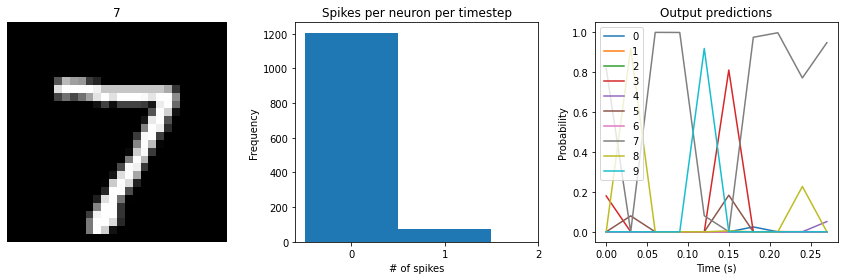

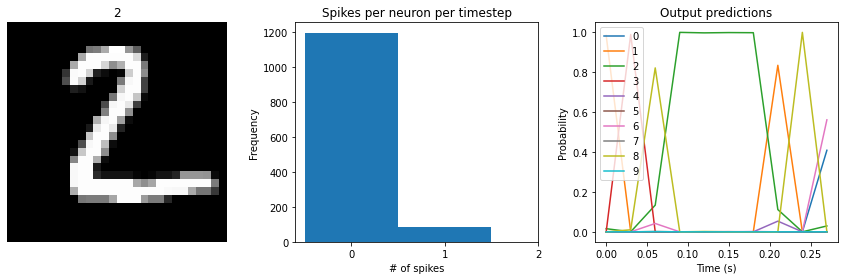

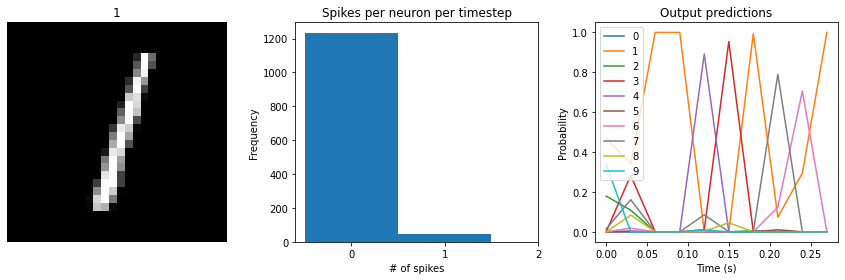

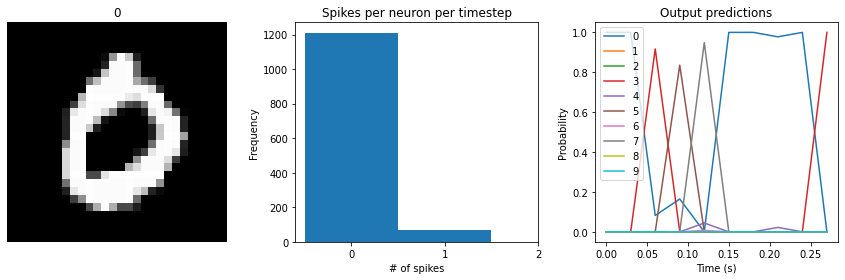

In [99]:
check_output(spikeaware_model)

In [100]:
regularized_model = tf.keras.Sequential(
    [
        tf.keras.layers.Reshape((-1, 28 * 28), input_shape=(None, 28, 28)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128)),
        keras_spiking.SpikingActivation(
            "relu",
            dt=dt_from_prev,
            spiking_aware_training=True,
            # add activity regularizer to encourage spike rates between 10 and 20 Hz
            activity_regularizer=keras_spiking.regularizers.L2(
                l2=1e-4, target=(10, 20)
            ),
        ),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(10),
    ]
)

train(regularized_model, train_sequences, test_sequences)

Epoch 1/10
1875/1875 [==============================] - 9s 3ms/step - loss: 16.4564 - accuracy: 0.7130
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 17.3128 - accuracy: 0.8532
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 17.3235 - accuracy: 0.8563
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 17.2949 - accuracy: 0.8662
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 17.3022 - accuracy: 0.8664
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 17.2937 - accuracy: 0.8697
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 17.2819 - accuracy: 0.8718
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 17.3025 - accuracy: 0.8708
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 17.3001 - accuracy: 0.8689
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - lo

Test accuracy: 87.98%
Spike rate per neuron (Hz): min=3.33 mean=13.78 max=33.33


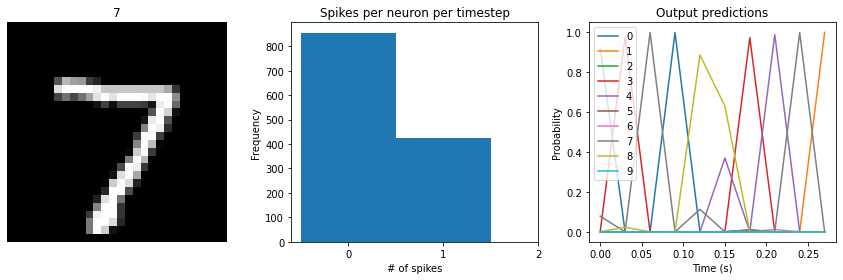

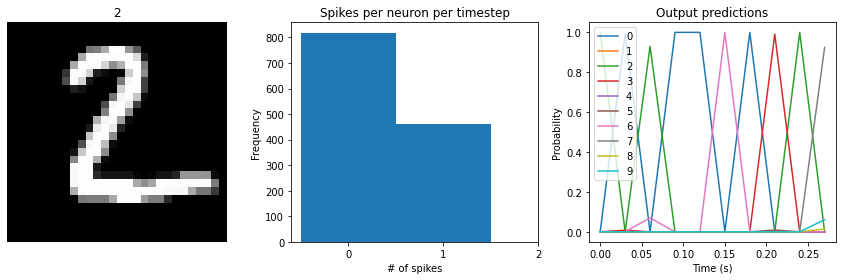

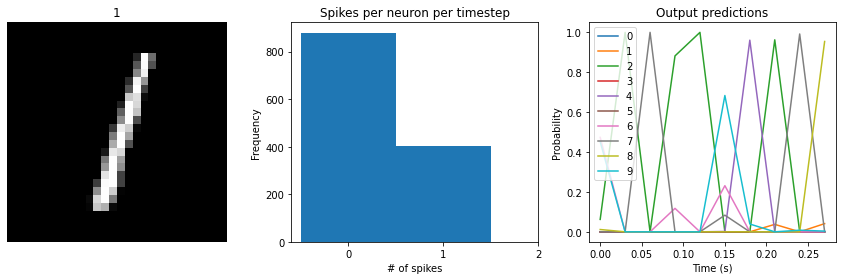

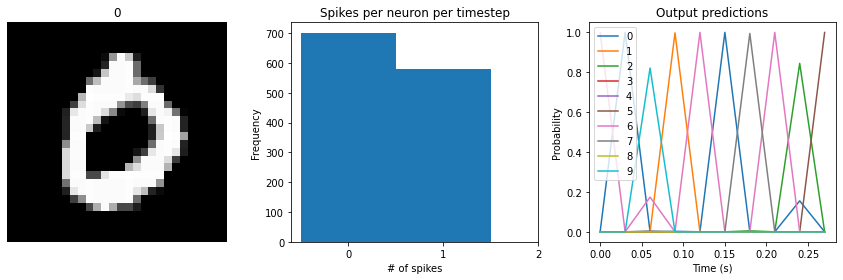

In [101]:
check_output(regularized_model)

We can see that the spike rates have moved towards the 10-20 Hz target we specified. However, the test accuracy has dropped, since we’re adding an additional optimization constraint. (The accuracy is still higher than the original result with `dt=0.01`, due to the higher spike rates.) We could lower the regularization weight to allow more freedom in the firing rates. Or we could use `keras_spiking.regularizers.Percentile`, which allows more freedom for outliers. Again, this is a tradeoff that is made between controlling the firing rates and optimizing accuracy, and the best value for that tradeoff will depend on the particular application (e.g., how important is it that spike rates fall within a particular range?).

Note that in some cases it may be better to use regularization with `spiking_aware_training=False`, as the regularization may perform better when the value being regularized is smoother. It may also help to adjust the weight initialization so that the initial firing rates are closer to the desired range, so that there are smaller adjustments required by the regularizer.



In [102]:
regularized_model = tf.keras.Sequential(
    [
        tf.keras.layers.Reshape((-1, 28 * 28), input_shape=(None, 28, 28)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128)),
        keras_spiking.SpikingActivation(
            "relu",
            dt=dt_from_prev,
            spiking_aware_training=True,
            # add activity regularizer to encourage spike rates between 10 and 20 Hz
            activity_regularizer=keras_spiking.regularizers.Percentile(
                l2=0.01, target=(10, 20)
            ),
        ),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(10),
    ]
)

train(regularized_model, train_sequences, test_sequences)

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 53.3684 - accuracy: 0.6442
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 53.7077 - accuracy: 0.7559
Epoch 3/10
1875/1875 [==============================] - 5s 2ms/step - loss: 53.8926 - accuracy: 0.7632
Epoch 4/10
1875/1875 [==============================] - 5s 2ms/step - loss: 53.9791 - accuracy: 0.7725
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 54.0704 - accuracy: 0.7775A: 
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 54.1130 - accuracy: 0.7797
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 54.1258 - accuracy: 0.7882
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 54.1992 - accuracy: 0.7816
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 54.2145 - accuracy: 0.7848
Epoch 10/10
1875/1875 [==============================] - 5s 2ms/step -

Test accuracy: 79.03%
Spike rate per neuron (Hz): min=0.00 mean=0.57 max=6.67


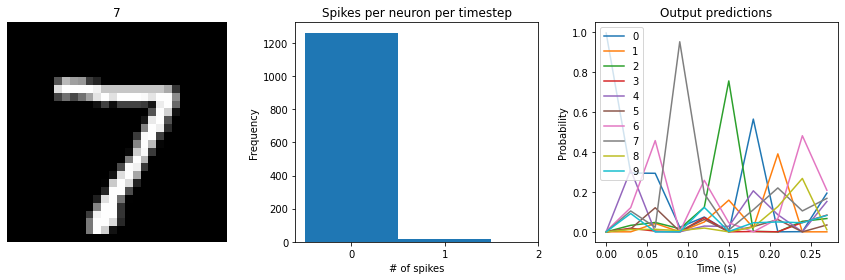

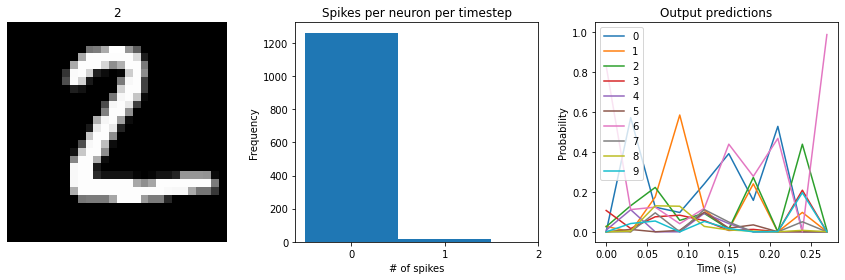

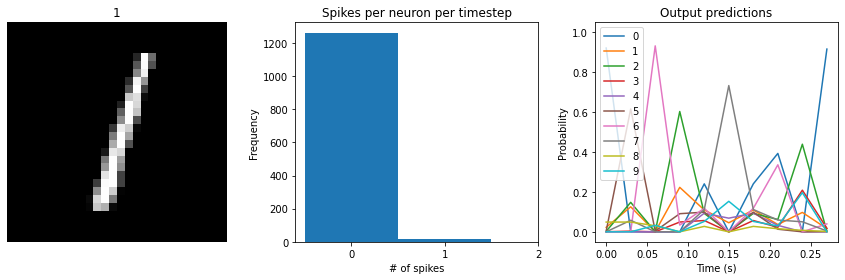

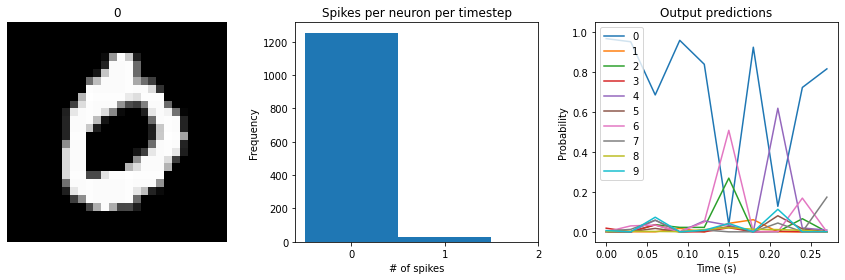

In [103]:
check_output(regularized_model)

In [105]:
# change regularizer weighting over 10 increments

def multi_train(input_model, train_x, test_x):
    input_model.compile(
        optimizer="adam",
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    input_model.fit(train_x, train_labels, epochs=10, verbose=0)

    _, test_acc = input_model.evaluate(test_x, test_labels, verbose=2)
    _, train_acc = input_model.evaluate(train_x, train_labels, verbose=2)

    #print("\nTest accuracy:", test_acc)
    return input_model, test_acc, train_acc

def make_spiking_model_l2(l2_weight=1e-4, spike_aware=True):

    regularized_model = tf.keras.Sequential(
        [
            tf.keras.layers.Reshape((-1, 28 * 28), input_shape=(None, 28, 28)),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128)),
            keras_spiking.SpikingActivation(
                "relu",
                dt=dt_from_prev,
                spiking_aware_training=spike_aware,
                # add activity regularizer to encourage spike rates between 10 and 20 Hz
                activity_regularizer=keras_spiking.regularizers.L2(
                    l2=l2_weight, target=(10, 20)
                ),
            ),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(10),
        ]
    )
    return regularized_model

def make_spiking_model_l1(l1_weight=1e-4, spike_aware=True):

    regularized_model = tf.keras.Sequential(
        [
            tf.keras.layers.Reshape((-1, 28 * 28), input_shape=(None, 28, 28)),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128)),
            keras_spiking.SpikingActivation(
                "relu",
                dt=dt_from_prev,
                spiking_aware_training=spike_aware,
                # add activity regularizer to encourage spike rates between 10 and 20 Hz
                activity_regularizer=keras_spiking.regularizers.L1(
                    l1=l1_weight, target=(10, 20)
                ),
            ),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(10),
        ]
    )
    return regularized_model

In [ ]:
weights = [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 0.2, 0.5, 1]
l2_train_accuracy = []
l2_test_accuracy = []
l2_models = []
l1_train_accuracy = []
l1_test_accuracy = []
l1_models = []

for i in range(2):
    
    for weight in weights:
        print("Training model spike_aware: {} l2 weight: {}".format(i, weight))

        regularized_model = make_spiking_model_l2(l2_weight=weight, spike_aware=i)

        trained, test_acc, train_acc = multi_train(regularized_model, train_sequences, test_sequences)

        l2_test_accuracy.append(test_acc)
        l2_train_accuracy.append(train_acc)
        l2_models.append(trained)
        
        print("Training model spike_aware: {} l1 weight: {}".format(i, weight))

        regularized_model = make_spiking_model_l1(l1_weight=weight, spike_aware=i)

        trained, test_acc, train_acc = multi_train(regularized_model, train_sequences, test_sequences)

        l1_test_accuracy.append(test_acc)
        l1_train_accuracy.append(train_acc)
        l1_models.append(trained)

Training model spike_aware: 0 l2 weight: 1e-06
313/313 - 1s - loss: 0.3658 - accuracy: 0.9460
1875/1875 - 5s - loss: 0.2825 - accuracy: 0.9574
Training model spike_aware: 0 l1 weight: 1e-06


In [86]:
num_weights = len(weights)

fig, ax = plt.subplots(2,1, figsize=(6,10))

ax[0].plot(weights, l1_train_accuracy[:num_weights], '-bo')
ax[0].plot(weights, l1_test_accuracy[:num_weights], '-ro')
ax[0].plot(weights, l1_train_accuracy[num_weights:], '-co')
ax[0].plot(weights, l1_train_accuracy[num_weights:], '-mo')
ax[1].plot(weights, l2_train_accuracy[:num_weights], '-bo')
ax[1].plot(weights, l2_test_accuracy[:num_weights], '-ro')
ax[1].plot(weights, l2_train_accuracy[num_weights:], '-co')
ax[1].plot(weights, l2_test_accuracy[num_weights:], '-mo')
ax[0].grid()
ax[1].grid()

ax[0].set_xscale('log')
ax[1].set_xscale('log')

plt.suptitle('Accuracy after 10 epochs vs. L1 and L2 regularization weights')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('L1 Weight')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('L2 Weight')

ax[0].legend(['Training', 'Testing', 'Spikeaware Training', 'Spikeaware Testing'])
ax[1].legend(['Training', 'Testing', 'Spikeaware Training', 'Spikeaware Testing'])
plt.show()

Again, this is a tradeoff that is made between controlling the firing rates and optimizing accuracy, and the best value for that tradeoff will depend on the particular application (e.g., how important is it that spike rates fall within a particular range?).

Test accuracy: 93.63%
Spike rate per neuron (Hz): min=0.00 mean=6.59 max=50.00


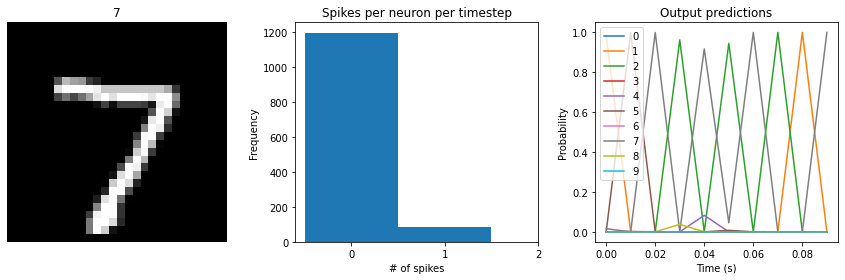

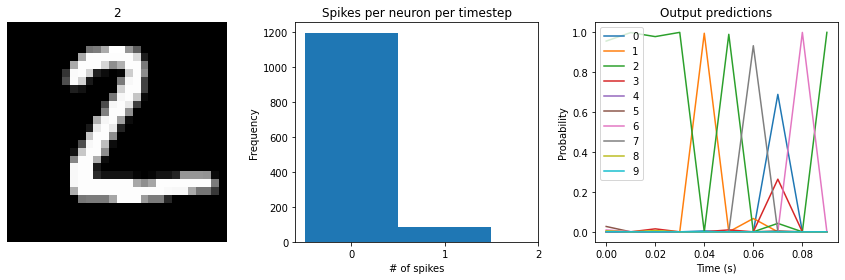

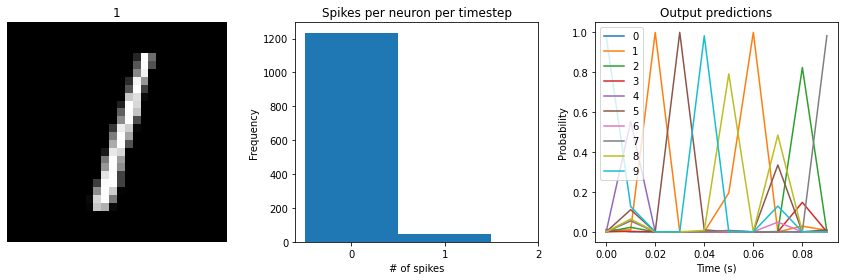

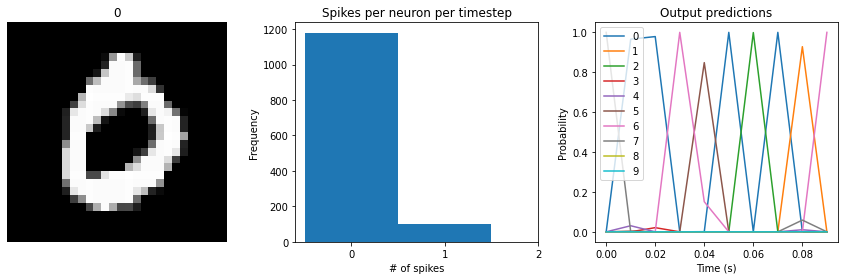

In [87]:
# Output of L2 at weight 10E-6, spikeaware

check_output(models[num_weights])

Test accuracy: 67.17%
Spike rate per neuron (Hz): min=0.00 mean=10.92 max=20.00


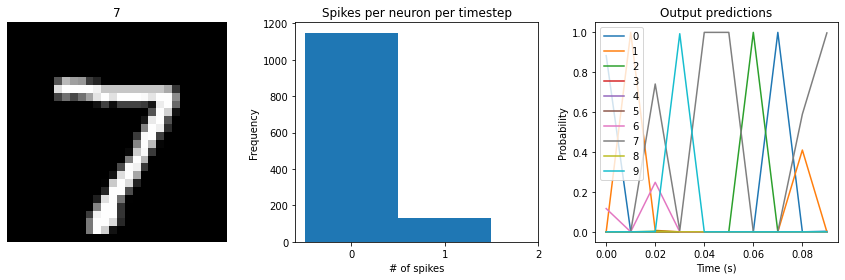

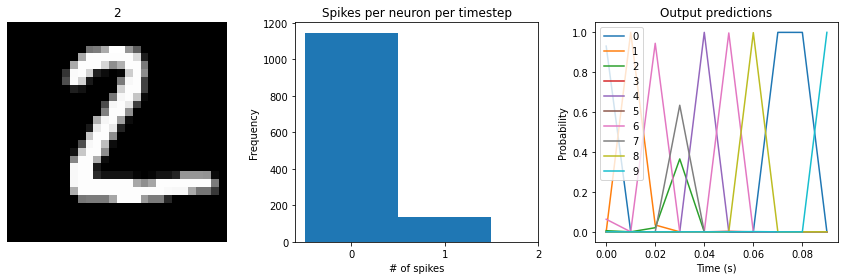

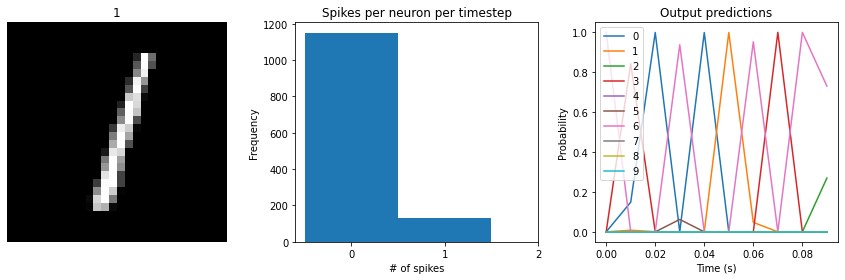

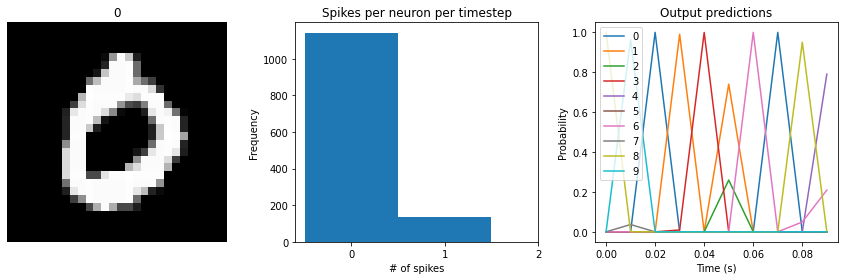

In [88]:
check_output(models[num_weights+3])

Test accuracy: 12.05%
Spike rate per neuron (Hz): min=0.00 mean=10.96 max=20.00


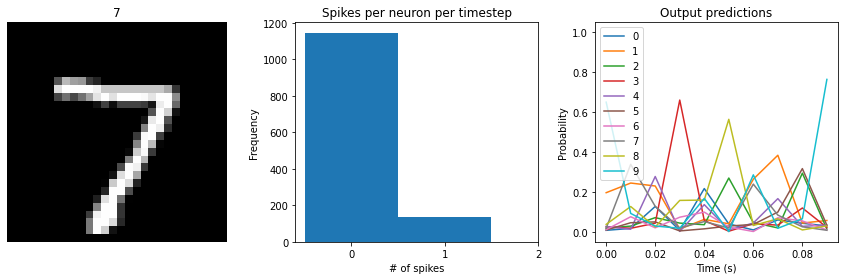

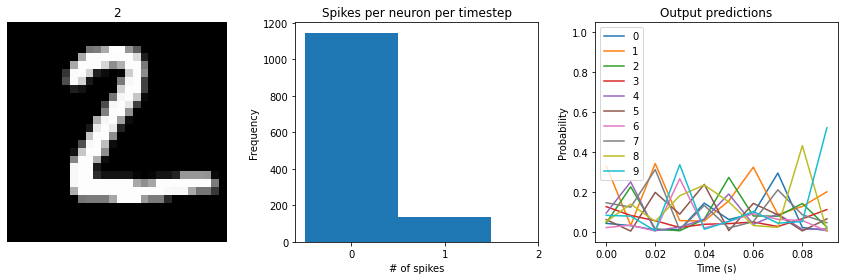

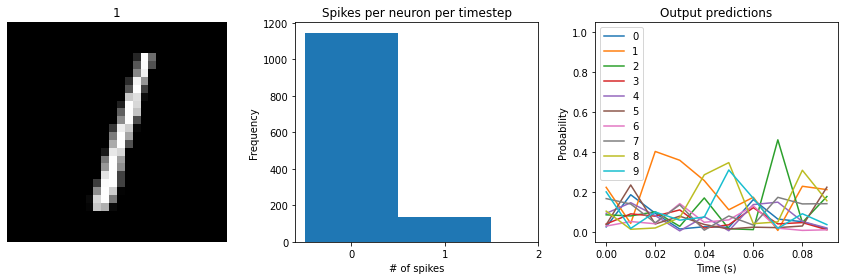

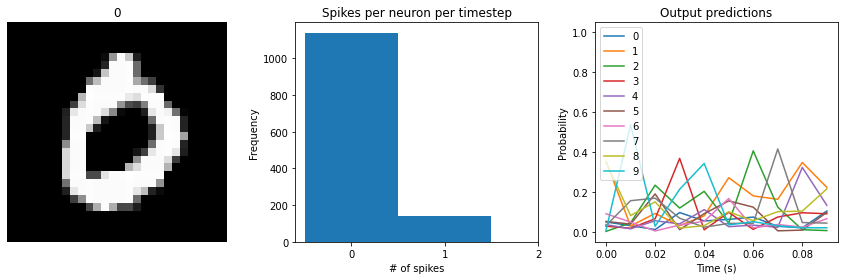

In [89]:
check_output(models[-1])

In [90]:
# Output of L2 at weight 1E-6, spikeaware

check_output(l2_models[num_weights])

In [91]:
check_output(l2_models[num_weights+3])

In [92]:
check_output(l2_models[-1])